In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/skeyenet-master/"
%cd gdrive/My\ Drive/skeyenet-master/

Mounted at /content/gdrive/
/content/gdrive/My Drive/skeyenet-master


In [ ]:
ls

Data/    output.png        road_mapper_final.h5
Images/  README.md         Src/
LICENSE  requirements.txt  TO_VINOD_V2_12OCT2020/


## Imports


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

## Loading Data

In [ ]:
# IMAGE_HEIGHT = IMAGE_WIDTH = 513
# NUM_CHANNELS = 3
# image_file = './Data/road_images.h5py'
# mask_file = './Data/road_masks.h5py'

In [ ]:
import cv2
import glob
import numpy as np

masks = []
# sorted(glob.glob('*.PNG'))
# files = glob.glob ("./TO_VINOD_V2_12OCT2020/MASKS/*.PNG")
for infile in sorted(glob.glob('./TO_VINOD_V2_12OCT2020/MASKS/*.PNG')):
    print("Current File Being Processed is: " + infile)
    image = cv2.imread (infile)
    image=image/255
    masks.append (image)
# sorted(files, key=lambda name: int(name[39:-4]))

# for myFile in files:
#     print(myFile)
#     image = cv2.imread (myFile)
#     masks.append (image)


masks=np.array(masks)
print('masks shape:', masks.shape)

Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS0.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS1.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS10.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS100.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS101.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS102.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS103.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS104.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS105.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS106.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS107.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS108.PNG
Current File Being Processed is: ./TO_VINOD_V

In [ ]:
import cv2
import glob
import numpy as np

images = []
# sorted(glob.glob('*.png'))
# files = glob.glob ("./TO_VINOD_V2_12OCT2020/RASTER/*.JPG")
# sorted(files, key=lambda name: int(name[40:-4]))
# for myFile in files:
#     print(myFile)
#     image = cv2.imread (myFile)
#     images.append (image)
for infile in sorted(glob.glob('./TO_VINOD_V2_12OCT2020/RASTER/*.JPG')):
    print("Current File Being Processed is: " + infile)
    image = cv2.imread (infile)
    image=image/255
    images.append (image)

# print('images shape:', np.array(images).shape)
images = np.array(images)
print('images shape:', images.shape)

Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS0.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS1.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS10.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS100.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS101.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS102.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS103.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS104.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS105.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS106.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS107.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS108.JPG
Current File Being Processed is: 

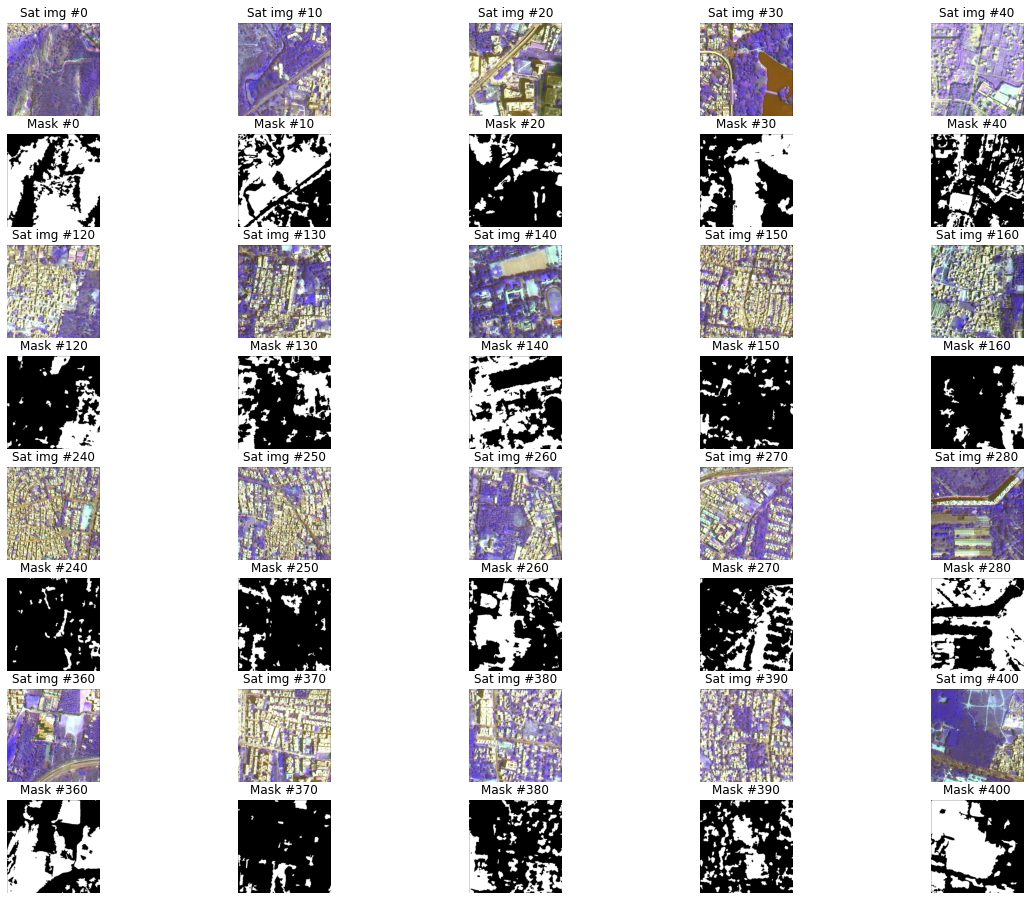

In [ ]:
 plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

## Metrics


In [ ]:
# from keras import backend as K
# def iou_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#   union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#   iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
#   return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
print(masks.shape)
print(images.shape)
# print(images.shape)

(415, 513, 513, 3)
(415, 513, 513, 3)


In [ ]:
img_rows = 256
img_cols = 256
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, imgs.shape[3]))
    for i in range(imgs.shape[0]):
        imgs_p[i] = cv2.resize(imgs[i], (img_cols, img_rows))

    #imgs_p = imgs_p[..., np.newaxis]
    return imgs_p
masks=preprocess(masks)
print(masks.shape)

(415, 256, 256, 3)


In [ ]:
img_rows = 256
img_cols = 256
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, imgs.shape[3]))
    for i in range(imgs.shape[0]):
        imgs_p[i] = cv2.resize(imgs[i], (img_cols, img_rows))

    #imgs_p = imgs_p[..., np.newaxis]
    return imgs_p
# masks=preprocess(masks)
images=preprocess(images)
print(images.shape)

(415, 256, 256, 3)


## Splitting data

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(332, 256, 256, 3)
(332, 256, 256, 3)
TEST SET
(83, 256, 256, 3)
(83, 256, 256, 3)


##Model

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization
# from tensorflow.keras.layers.core import Dropout, Lambda
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose
# from tensorflow.keras.layers.pooling import MaxPooling2D
# from tensorflow.keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model, load_model


In [ ]:
inputs = Input((img_rows, img_cols, 3))
# s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
# conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
# conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
# conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
# conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
# conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
# conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
# conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
# conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
# conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(3, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

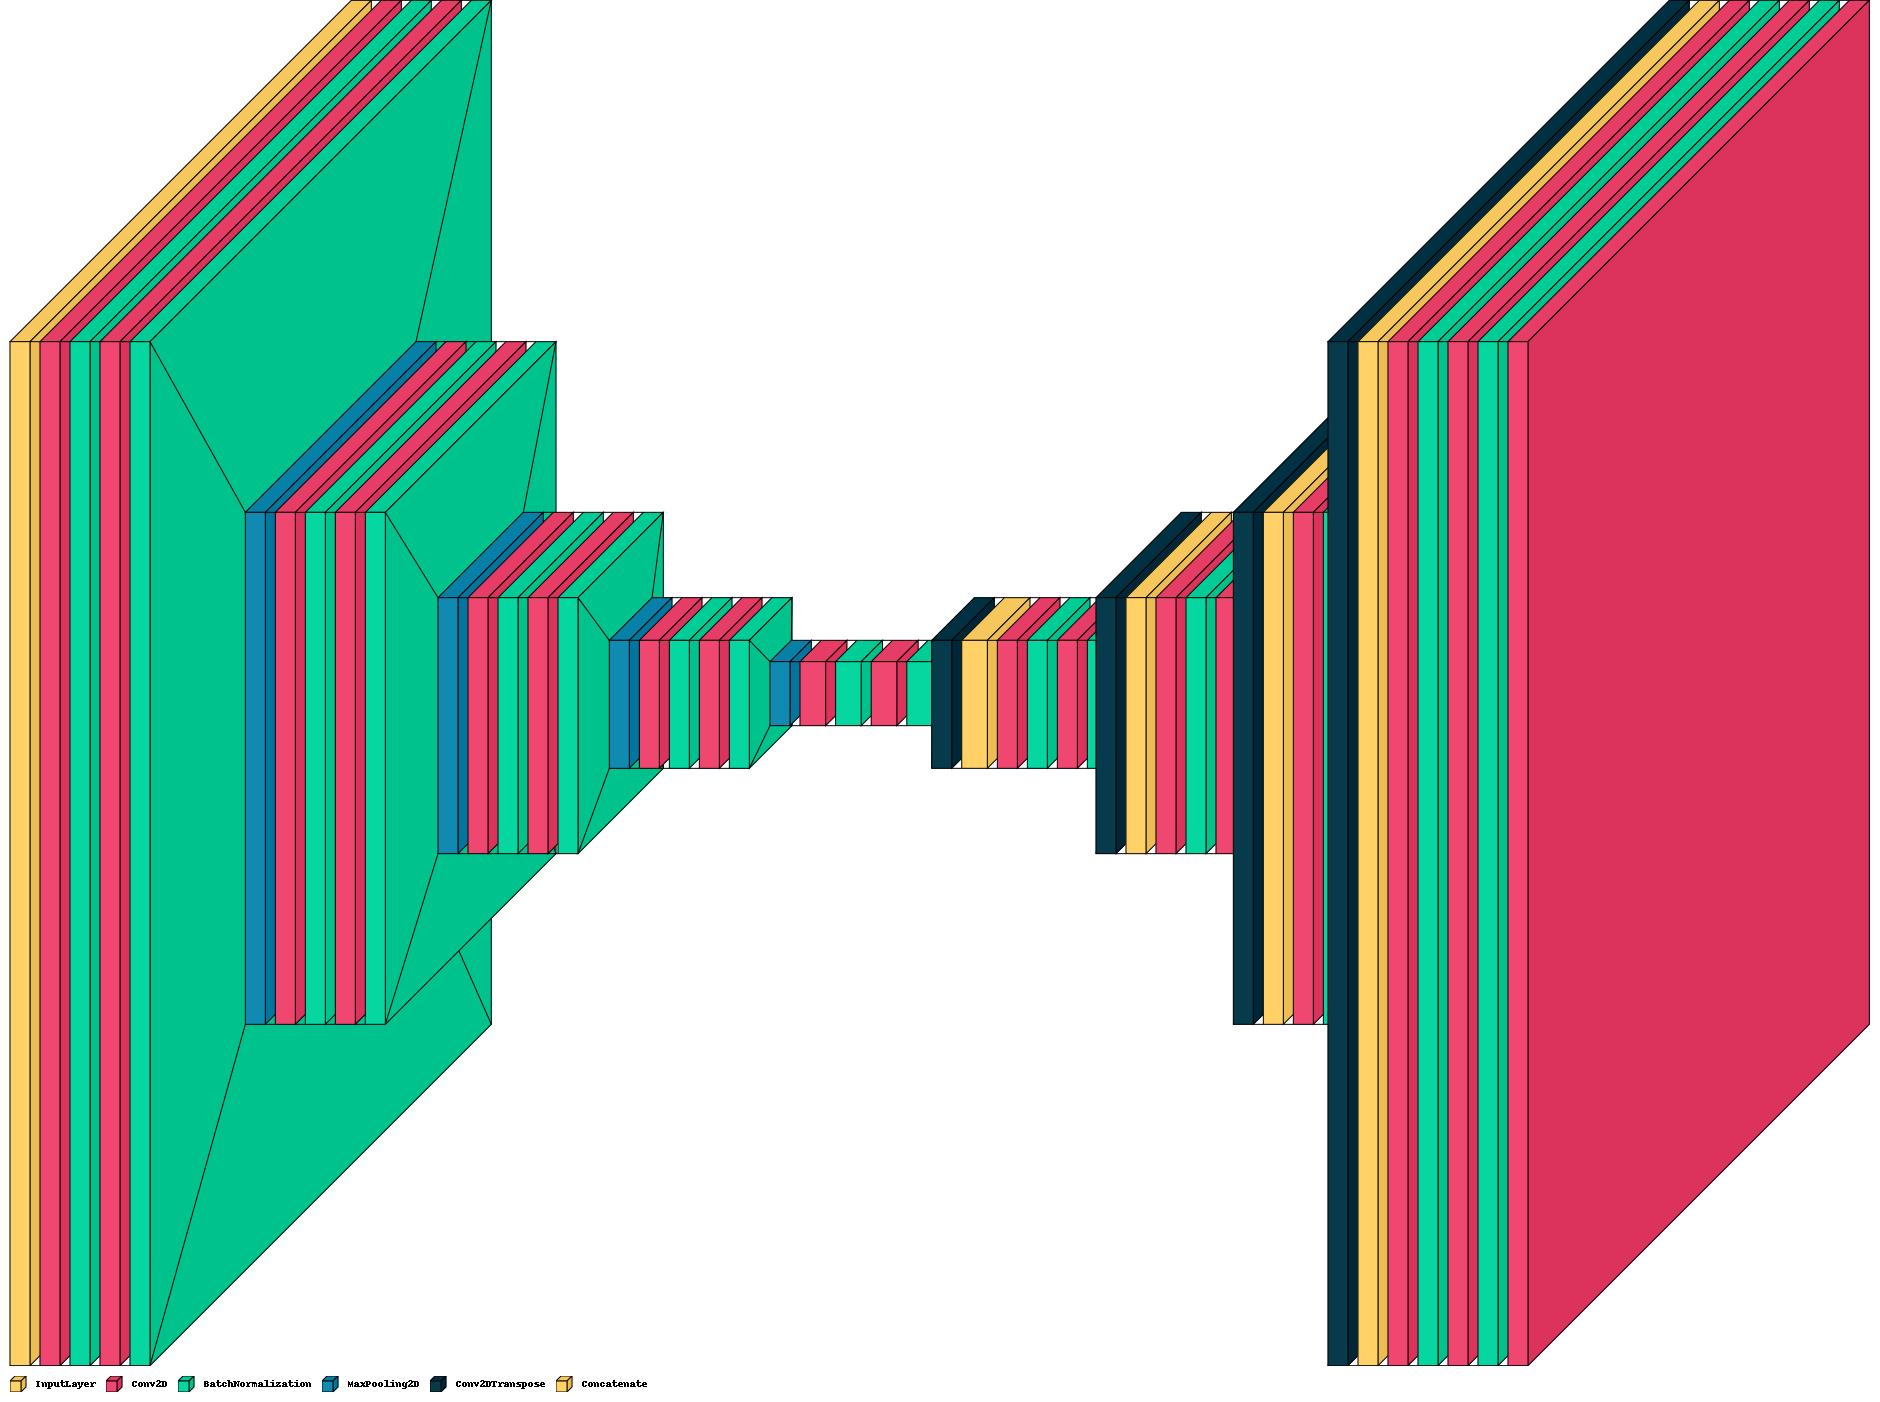

In [ ]:
import visualkeras

# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model,legend=True, to_file='output.png') # write to disk
# visualkeras.layered_view(model,legend=True, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

In [ ]:
pip install visualkeras

     |████████████████████████████████| 798kB 5.2MB/s 


### HYPER_PARAMETERS

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 8

In [ ]:
pip install TensorboardColab

  Created wheel for TensorboardColab: filename=tensorboardcolab-0.0.22-cp37-none-any.whl size=3860 sha256=d76c8d77bbd184ac3c97b7b2a51ffdff6eb1138b9ed574fa81a5229f8f201e09
  Stored in directory: /root/.cache/pip/wheels/c4/aa/a0/3aaf4f1a66adbdab9b7bdd4c96db8ada89eb7cd87200cfdd32
Successfully built TensorboardColab


### Initializing Callbacks

In [ ]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [ ]:
# pip install tensorboardcolab

In [ ]:
# tbc=TensorBoardColab()

In [ ]:
model_path = "./Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [ ]:
from tensorflow.keras.metrics import Recall, Precision, Accuracy

opt =Adam(LEARNING_RATE)
metrics = [dice_coef, Recall(), Precision(),Accuracy()]
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=metrics)

In [ ]:
history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE
                    )#/255 for train masks

Epoch 1/100
38/38 [==============================] - 3s 84ms/step - loss: 0.0457 - dice_coef: 0.9545 - recall: 0.9328 - precision: 0.9750 - accuracy: 0.0214 - val_loss: 0.1782 - val_dice_coef: 0.8282 - val_recall: 0.8336 - val_precision: 0.8431 - val_accuracy: 0.0010
Epoch 2/100
38/38 [==============================] - 3s 80ms/step - loss: 0.0488 - dice_coef: 0.9511 - recall: 0.9302 - precision: 0.9727 - accuracy: 0.0232 - val_loss: 0.1814 - val_dice_coef: 0.8254 - val_recall: 0.8312 - val_precision: 0.8380 - val_accuracy: 8.9548e-04
Epoch 3/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0453 - dice_coef: 0.9549 - recall: 0.9333 - precision: 0.9754 - accuracy: 0.0187 - val_loss: 0.1779 - val_dice_coef: 0.8289 - val_recall: 0.8410 - val_precision: 0.8367 - val_accuracy: 0.0013
Epoch 4/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0457 - dice_coef: 0.9543 - recall: 0.9333 - precision: 0.9755 - accuracy: 0.0259 - val_loss: 0.1799 - val_dice_coef:

In [ ]:
model.save("road_mapper_final.h5")

## Testing our Model

### On Test Images

In [ ]:
model = load_model("road_mapper_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [ ]:
model.evaluate(test_images, test_masks)

3/3 [==============================] - 0s 93ms/step - loss: 0.1508 - dice_coef: 0.8482 - recall: 0.8507 - precision: 0.8604 - accuracy: 0.0764


[0.1507677137851715,
 0.8481804728507996,
 0.8506600260734558,
 0.8604221343994141,
 0.07636980712413788]

In [ ]:
predictions = model.predict(test_images, verbose=1)

3/3 [==============================] - 1s 139ms/step


In [ ]:
thresh_val = 0.2
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

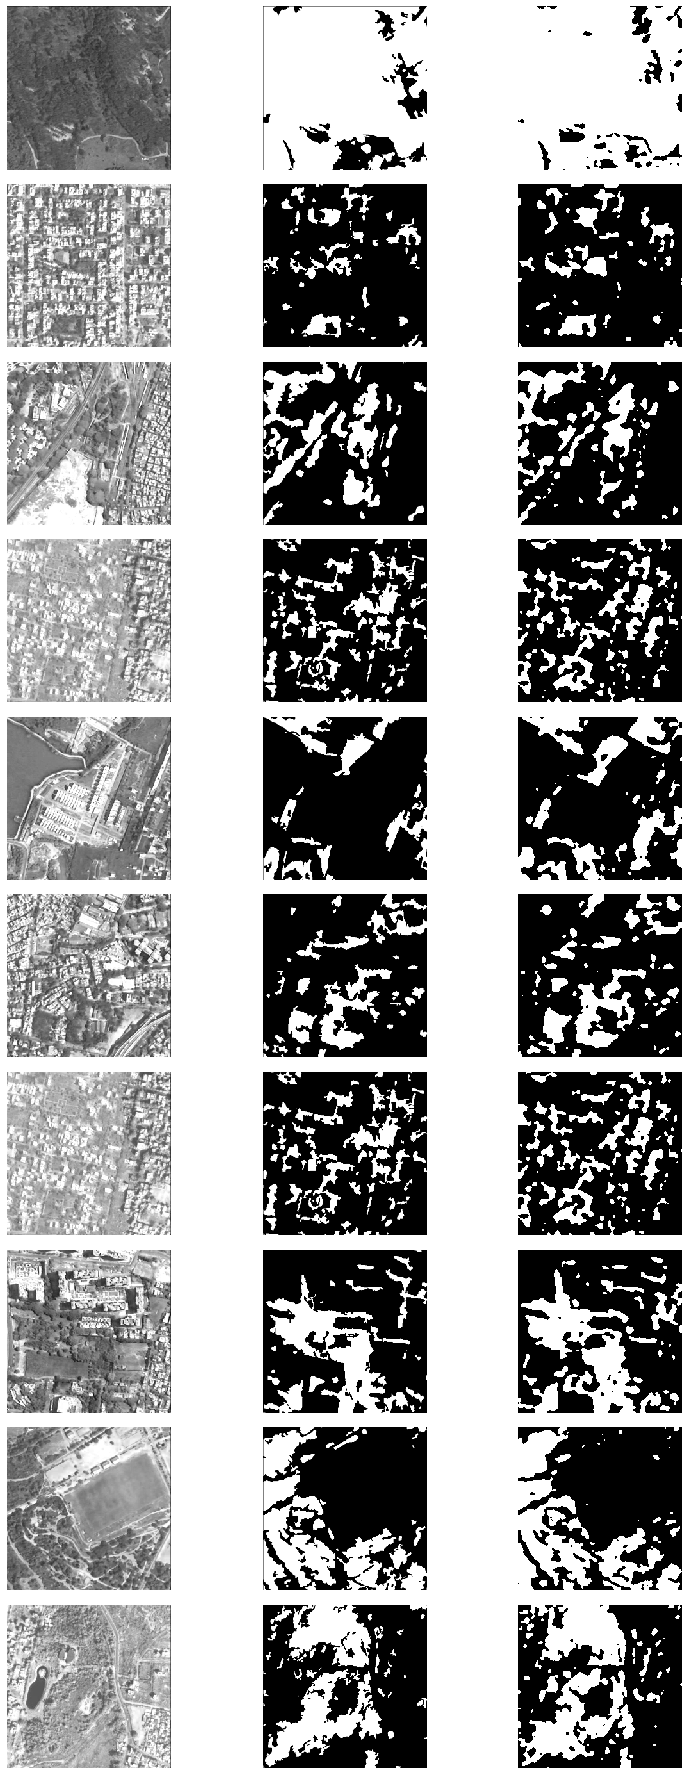

In [ ]:
import matplotlib.gridspec as gridspec

ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0, hspace=0) # set the spacing between axes. 
f.subplots_adjust(left=0 )

for i in range(1, num_samples*4, 4):
  
  ix = random.randint(0, len(predictions))
  # print(ix)
  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  # plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  # plt.title("Groud Truth")
  plt.axis('off')

  # f.add_subplot(num_samples, 4, i+2)
  # imshow(np.squeeze(predictions[ix][:,:,0]))
  # plt.title("Prediction")
  # plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  # im_gray = cv2.imread(predicton_threshold[ix][:,:,0], cv2.IMREAD_GRAYSCALE)
  (thresh, im_bw) = cv2.threshold(predicton_threshold[ix][:,:,0], 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  imshow(im_bw)
  # plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()